In [185]:
%load_ext autoreload
%autoreload 2
import os
import glob
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
pd.options.display.max_columns = 999
import sys
sys.path.append("../../Code")
import vader
import settings as s
import utils 
import seaborn as sns 
import afinns as af
import s140
import opinion_lexicon as op
import so_cal as sc
import languages as lang
import files as f
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
stopWords = set(stopwords.words('english'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [13]:
guests = pd.read_csv(os.path.join('..','2','nr_restrict_guests.csv'), low_memory=False, index_col=0)
hosts = pd.read_csv(os.path.join('..','2','nr_restrict_hosts.csv'), low_memory=False, index_col=0)

In [486]:
guest_reviews = pd.read_csv(os.path.join('..','2','len_lang_restrict_reviews.csv'), low_memory=False, index_col=0)

In [487]:
len(guest_reviews)

225090

In [488]:
needs_guest_trans = guest_reviews[~guest_reviews.id.isin(guest_reviews_trans.id)]

In [489]:
guest_reviews = guest_reviews.join(guest_reviews_trans[['id', 'isTranslated']].set_index('id'), on='id')

In [504]:
comments = []
for i, r in guest_reviews.iterrows():
    if r['isTranslated'] == 1:
        comments.append("".join(guest_reviews_trans[guest_reviews_trans.id == r['id']].comments))
    elif r['id'] in set(needs_guest_trans.id)  or r['isTranslated'] == 0:
        comments.append(r.comments)

In [505]:
len(comments)

225090

In [506]:
guest_reviews.comments = comments

In [514]:
guest_reviews.isTranslated = guest_reviews.isTranslated.fillna("0.0")

In [518]:
guest_reviews.isTranslated = guest_reviews.isTranslated.astype(int)

In [519]:
guest_reviews = guest_reviews.drop(['translated', 'other_langs'], axis=1)

In [507]:
needs_trans = guest_reviews[guest_reviews.isTranslated.isnull()]

### Get Reviews

In [ ]:
# Merge Data - done
# Get Vocabulary - Done
# Get Unknown Words 
# Get Distribution - unknown words - done 
# Get Correction dictionary - done
# Manually Correct  - done 
# Correction Dictionary - done 
# Go Through All Reviews Correct - Translated Marker  + Spelling Corrected Marker - done

In [174]:
def get_translated_reviews(tbl):
    new_tbl = tbl.copy()
    reviews = []
    translated_markers = []
    for i, r in new_tbl.iterrows():
        if r['translated'] not in [np.nan, None, 'nan', 'None'] and  r['translated'] != r['comments']:
            reviews.append(r['translated'])
            translated_markers.append(1)
        else:
            reviews.append(r['comments'])
            translated_markers.append(0)
    new_tbl['comments'] = reviews
    new_tbl['isTranslated'] = translated_markers
    if 'translated' in set(new_tbl.columns):
        new_tbl = new_tbl.drop(['translated'], axis=1)
    if 'other_langs' in set(new_tbl.columns):
        new_tbl = new_tbl.drop(['other_langs'], axis=1)
    return new_tbl

In [450]:
guest_reviews_trans = get_translated_reviews(g_reviews)

In [424]:
host_reviews_trans = get_translated_reviews(host_reviews)

In [425]:
host_reviews_trans.to_csv('host_reviews_trans.csv')

In [521]:
guest_reviews.to_csv('guest_reviews_trans.csv')

In [522]:
guest_reviews_trans = pd.read_csv('guest_reviews_trans.csv', index_col=0)

In [523]:
host_reviews_trans = pd.read_csv('host_reviews_trans.csv', index_col=0)

## Merge Host and Guest Reviews

In [526]:
data = pd.concat([guest_reviews_trans[['comments']], host_reviews_trans[['comments']]]).reset_index()

In [527]:
vocab_count, vocab, idf = lang.pipeline(data, 'comments', stopWords, encode_data=False)

## Get Vocabulary

In [528]:
vocab_table = lang.create_vocab_count_table(vocab_count)

In [529]:
vocab_table.sort_values(by='counts', ascending=False).head()

,counts,word
52,153655,apartment
2,146334,great
1,130789,place
21,122248,stay
23,97437,location


## Find out words not in word2vec

In [530]:
from gensim.models.keyedvectors import KeyedVectors
# should load in 2 min
w2v = KeyedVectors.load_word2vec_format('../../Tools/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

In [531]:
known, unknown, nums = lang.extract_known_words(set(vocab.keys()), w2v, True)

In [532]:
unknown_vocab = vocab_table[vocab_table['word'].isin(unknown)].sort_values(by='counts', ascending=False)

In [533]:
len(unknown_vocab)

21968

In [534]:
unknown_vocab.head()

,counts,word
343,6112,neighbourhood
752,4365,airbnb
36,3510,cosy
677,1202,appartement
830,1058,travelling


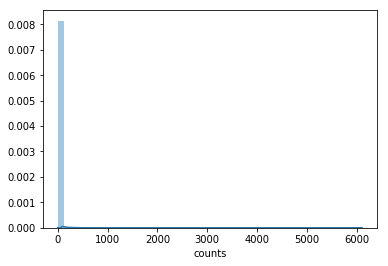

In [535]:
sns.distplot(unknown_vocab.counts)
plt.show()

In [536]:
exclude_words = {'airbnb', 'lyft','NYC', "airbnb'ers", "bnb", "nyc'", "airbnbs"}

In [537]:
exclude_vocab = unknown_vocab[(unknown_vocab.word.str.contains("'s")) | (unknown_vocab.word.str.contains("'d")) | (unknown_vocab.word.str.lower().isin(exclude_words))]




In [538]:
needs_correction = unknown_vocab[(unknown_vocab.counts > 5) & (~unknown_vocab.word.isin(exclude_vocab.word.unique()))]

In [539]:
len(needs_correction)

934

In [253]:
from spellchecker import SpellChecker
spell = SpellChecker()


In [258]:
corrections = {}
for word in list(needs_correction['word']):
    corrections[word] = spell.correction(word)
    

In [262]:
corrections_bing =   {w:get_spell_correction(w) for w in list(needs_correction['word'])}

## Creating unknown tables

In [282]:
pyspell_unknowns = []
pyspell_corrections = []
for w, c in corrections.items():
    pyspell_unknowns.append(w)
    pyspell_corrections.append(c if c != None else None)
pyspell_spell = pd.DataFrame({'word':pyspell_unknowns, 'corrections':pyspell_corrections})

In [272]:
unknowns = []
bing_corrections = []
for w, c in corrections_bing.items():
    unknowns.append(w)
    bing_corrections.append(c[0] if c != None else None)
bing_spell = pd.DataFrame({'word':unknowns, 'corrections':bing_corrections})

In [275]:
bing_spell.to_csv("spell_corrections_bing.csv")

## Creating correction dictionary

In [551]:
spell_corrections = pd.read_csv("spell_correction_final.csv", index_col=0)

In [552]:
correction_dict = {r['word']:r['final_corrections'] for i, r in spell_corrections.iterrows()}
    

## Correct reviews

In [555]:
host_reviews_spell = spell_correct(correction_dict, host_reviews_trans, 'comments')

In [556]:
host_reviews_spell[host_reviews_spell.isCorrected == 1].head(1)

,idHostReview,host_name,reviewer_id,recipient_id,comments,total_host_reviews,token_len,num_of_sents,google_langs,google_langs_conf,isTranslated,isCorrected
3012,3013,Michele,9107715,35063982,Great guest courteous,10,3,1,en,1.0,0,1


In [557]:
guest_reviews_spell = spell_correct(correction_dict, guest_reviews_trans, 'comments')

In [558]:
guest_reviews_spell[guest_reviews_spell.isCorrected == 1].head(1)

,idGuestReview,id,date,reviewer_id,listing_id,recipient_id,comments,hostCancelled,token_len,num_of_sents,google_langs,google_langs_conf,langdetect_langs,langdetect_langs_conf,isTranslated,isCorrected
203,441,22938,2010-01-03,61471,4989,7118,Good location - easy access to Times Square and the subway. Apartment was a tight squeeze for 4 girls but loved the home deco and the cozy feel! Russell was very helpful. Great rooftop! Would recommend for 3 or less people.,N,40,5,en,1.0,en,0.999997,0,1


In [560]:
guest_reviews_spell.to_csv("guest_reviews_spell.csv")
host_reviews_spell.to_csv("host_reviews_spell.csv")

## Spelling Extra Work

In [284]:
pyspell_spell = pyspell_spell.rename(columns={'corrections':'pyspell_corrections'})

In [286]:
spell_corrections = spell_corrections.join(pyspell_spell[['word', 'pyspell_corrections']].set_index('word'), on='word')

In [288]:
final_corrections = []
spell_corrections.is_copy = False
for i, r in spell_corrections.iterrows():
    if r['corrections'] in [np.nan, None]:
        final_corrections.append(r['pyspell_corrections'])
    else:
        final_corrections.append(r['corrections'])
spell_corrections['final_corrections'] = final_corrections

In [266]:
pd.DataFrame({"corrections": list(corrections_bing.items())}).to_csv("spell_corrections.csv")

In [260]:
import http.client, urllib.parse, json
import time
def get_spell_correction(text):
    time.sleep(1)
    data = {'text': text}

    # NOTE: Replace this example key with a valid subscription key.
    key = 'e5dd4c2922114235a61ede29af8f8525'

    host = 'api.cognitive.microsoft.com'
    path = '/bing/v7.0/spellcheck?'
    params = 'mkt=en-us&mode=proof'

    headers = {'Ocp-Apim-Subscription-Key': key,
    'Content-Type': 'application/x-www-form-urlencoded'}

    conn = http.client.HTTPSConnection(host)
    body = urllib.parse.urlencode (data)
    conn.request ("POST", path + params, body, headers)
    response = conn.getresponse ()
    output = json.dumps(json.loads(response.read()), indent=4)
    
    suggestion = eval(output)['flaggedTokens'][0]['suggestions'][0] if ('flaggedTokens' in eval(output).keys()) and (len(eval(output)['flaggedTokens']) > 0) else None
    return (suggestion['suggestion'], suggestion['score']) if suggestion != None else None

# TRANSLATION _ DO NOT DELETE

## Get Comment Lengths

# Translation

In [5]:
host_reviews_all  = pd.read_csv('host_reviews_lang.csv', index_col=0)

### Show that Unknown ass english but has smilies

In [6]:
host_reviews_all[host_reviews_all.google_langs == 'unk']

,idHostReview,host_name,reviewer_id,recipient_id,comments,total_host_reviews,token_len,num_of_sents,google_langs,google_langs_conf
1847,456571,Anton,1153993.0,64236615,Great and nice guys and good communicators👍🏻,1,7,1,unk,0.0
1984,467212,G,1331850.0,41194992,Great as always. Thank you for treating my hom...,4,11,2,unk,0.0
2293,463565,Monika,143610690.0,13830679,Gary was a great guest. Excellent communicator...,10,20,4,unk,0.0
2950,210972,Miles,110874813.0,10593827,I HAD PRIVILEGE TO HAVE SOMEONE DO SPECIAL AND...,10,101,2,unk,0.0
2977,222343,Angela,1317884.0,88807205,She is my another wonderful guest. Deepika fol...,4,52,4,unk,0.0
3199,143796,K,66501870.0,72831843,Lovely guest 👌🏼,1,2,1,unk,0.0
3991,400172,Rachel,26640253.0,24575720,Jennifer is a wonderful guest. Super warm & fr...,2,18,4,unk,0.0
4183,404063,Terry,31451454.0,5796163,"Wow , My flat was left in excellent spotless c...",10,42,3,unk,0.0
4471,310382,Natcha,79385520.0,7132480,"PERFECT guest. Ricardo is a very clean, friend...",4,36,5,unk,0.0
4513,321949,Perikles,24274035.0,140723348,Katrin was our favorite guest until now. Very ...,3,20,2,unk,0.0


### Show that those as 'en' and confidence less than 1.0 are mainly due to it being short text

In [7]:
host_reviews_all[(host_reviews_all.google_langs_conf.astype(float) < 1.0) & (host_reviews_all.google_langs == 'en') ]

,idHostReview,host_name,reviewer_id,recipient_id,comments,total_host_reviews,token_len,num_of_sents,google_langs,google_langs_conf
16168,16169,Milos,14023066.0,2197216,Nice people. Ez communication.,2,4,2,en,0.989131
29141,29142,Tiffany,15424584.0,28364410,It was a pleasure hosting Jenai!,2,6,1,en,0.958974
30389,30390,Harper,15492140.0,23067658,Very nice couple!,1,3,1,en,0.988955
36647,36648,Lee,10235327.0,31881833,Perfect,5,1,1,en,0.972692
38489,38490,Nico,16316786.0,16883328,...,1,0,1,en,0.000000
50722,50723,Nathaniel,15906867.0,17463127,Junho was a great guest.,5,5,1,en,0.985258
67029,67030,Lola,17465563.0,1336747,.,10,0,1,en,0.000000
81492,81493,Jo,5466638.0,36193904,What a lovely couple! Isabelle and her husband...,1,52,6,en,0.939352
87035,87036,Julia,4835582.0,3703893,Meaza was great!,1,3,1,en,0.983599
92075,92076,Carolyn,21614073.0,24399628,Very nice couple,2,3,1,en,0.988955


### Restrict to those reviews that need translating

In [8]:
needs_translation = host_reviews_all[(host_reviews_all.google_langs != 'en') & (host_reviews_all.google_langs != 'unk')| ((host_reviews_all.google_langs_conf.astype(float) > 0.0) & (host_reviews_all.google_langs_conf.astype(float) < 1.0) & (host_reviews_all.token_len.astype(int) > 10))  ]



In [9]:
len(needs_translation)

32

In [11]:
needs_translation['translation'] = lang.get_english_text(needs_translation, 'comments')

/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
needs_translation

,idHostReview,host_name,reviewer_id,recipient_id,comments,total_host_reviews,token_len,num_of_sents,google_langs,google_langs_conf,translation
10504,10505,Fabian,13604945.0,10691848,"gente muy linda, un placer tenerlos aqui en to...",9,13,1,es,1.000000,"very nice people, a pleasure to have you here ..."
12430,12431,John,13736818.0,13822843,"As a host for the first time, I could not have...",7,183,12,fr,1.000000,"As a host for the first time, I could not ask ..."
35432,35433,Karima,16245979.0,33614650,Helena été une très bonne invité. Elle a laiss...,2,34,3,fr,1.000000,Helena was a very good guest. She left the apa...
43703,43704,Koseki,8678128.0,18970555,今回も出張でのご利用ありがとうございます。いつも通り綺麗にお使い頂き感謝します。,10,2,1,ja,1.000000,Thank you for using on business trip this time...
81492,81493,Jo,5466638.0,36193904,What a lovely couple! Isabelle and her husband...,1,52,6,en,0.939352,What a lovely couple! Isabelle and her husband...
98744,98745,Justin,24659272.0,82715568,An absolute,1,2,1,ende,0.622036,An absolute
300479,300480,Modesta,131848646.0,64450756,Ibrahim es un señor muy amable y Respetuoso fu...,1,21,1,es,1.000000,Ibrahim is a very kind and respectful gentlema...
300480,300481,Modesta,131848646.0,121339388,Maravillosa es una belleza de dama limpia educ...,1,21,1,es,1.000000,Marvelous is a clean lady beauty educated symp...
304153,304154,Carmelo,132983866.0,44395988,"Dos Excelentes jóvenes, ordenadas, respetuosas...",5,25,1,es,1.000000,"Two excellent young people, neat, respectful a..."
304156,304157,Carmelo,132983866.0,42287635,"Son dos jovenes muy educados, ordenados, limpi...",6,16,1,es,1.000000,"They are two young people very educated, neat,..."


In [129]:
pd.options.display.max_colwidth = 500

In [130]:
guest_reviews[(guest_reviews.google_langs == 'unk') & (guest_reviews.langdetect_langs_conf < 0.99)]

,idGuestReview,id,date,reviewer_id,listing_id,recipient_id,comments,hostCancelled,token_len,num_of_sents,google_langs,google_langs_conf,langdetect_langs,langdetect_langs_conf,other_langs,translated


In [131]:
needs_translation_guests = guest_reviews[((guest_reviews.google_langs != 'en') & (guest_reviews.google_langs != 'unk'))| ((guest_reviews.google_langs_conf.astype(float) < 1.0) & (guest_reviews.token_len > 10 )& (guest_reviews.google_langs_conf.astype(float) > 0.0))]

In [132]:
needs_translation_guests = lang.get_other_langs(needs_translation_guests)

In [133]:
needs_translation_guests

,idGuestReview,id,date,reviewer_id,listing_id,recipient_id,comments,hostCancelled,token_len,num_of_sents,google_langs,google_langs_conf,langdetect_langs,langdetect_langs_conf,other_langs,translated
7242,15736,846184,2012-01-07,923515,37197,160605,We had a grat time at Vejan place. I raccomand it,N,11,2,en,0.988222,en,0.999996,0,None
7957,17661,12623387,2014-05-06,7774366,44221,193722,"Samantha's loft is lovely: comfortable, organized, clean and well equipped/decorated, with enough space for two. She is easygoing, serious and always answered my e-mails quickly. I have to mention her good taste. The area is nice and convenient. Is not cheap - it's New York - but the place pays every cent. I would recommend for anyone, especially to couples looking for a nice place, with better price and experience than a boutique hotel. Para os brasileiros e colegas de língua: Recomendo ...",N,91,8,en,0.985258,en,0.999999,"[pt, pt]","Samantha's loft is lovely: comfortable, organized, clean and well equipped/decorated, with enough space for two.She is easygoing, serious and always answered my e-mails quickly.I have to mention her good taste.The area is nice and convenient.Is not cheap - it's New York - but the place pays every cent.I would recommend for anyone, especially to couples looking for a nice place, with better price and experience than a boutique hotel.For Brazilians and language partners: I recommend this apart..."
12788,25527,328979,2011-06-22,489245,62468,304081,"O apartamento do Rodrigo é muito BOM! A rua é segura, Metrô a distância de um quarteirão e meio. Há mercado, lojas, restaurantes, tudo o que vc precisa para uma boa estada em NYC. *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*- We meet the Rodrigo in the day that we arrive for he give us the keys. He was very pleasant and tell us how going to various places in New York. The clue about how to take the train Express to walk by NYC was very helpfull. We stay...",N,180,12,en,0.982518,en,0.999996,"[pt, pt, pt]","Rodrigo's apartment is very GOOD!The street is safe, Metro a block away and a half.There is a market, shops, restaurants, everything you need for a good stay in NYC.*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*- We meet the Rodrigo in the day that we arrive for he give us the keys.He was very pleasant and tell us how going to various places in New York.The clue about how to take the train Express to walk by NYC was very helpfull.We stayed in the apartament ..."
24958,51760,111396810,2016-10-31,75919244,213841,1039149,"It's a very good place to stay. Paul is a very nice host. Very helpful and he tries to make you feel comfortable. Everytime you need an advise he answers you very fast. His place is great, it's very close to a subway station (less than a block). Y si hablas español es muy fácil moverse por el vecindario, ya que casi todos son latinos en el East Harlem.",N,69,6,en,0.982517,en,0.999999,[es],"It's a very good place to stay.Paul is a very nice host.Very helpful and he tries to make you feel comfortable.Everytime you need an advise he answers you very fast.His place is great, it's very close to a subway station (less than a block).And if you speak Spanish it is very easy to move around the neighborhood, since almost everyone is Latino in East Harlem."
34538,72409,231744653,2018-02-02,18695446,328693,1013131,GOOD LOCATION!!! EVERYTHING IS GOOD EXCEPT THAT the bed is not clean enough.总体来说，好评。,N,15,2,en,0.980864,en,0.999997,[de],GOOD LOCATION!!!EVERYTHING IS GOOD EXCEPT THAT the bed is not clean enough.总体来说，好评。
34857,73016,56888752,2015-12-19,44222147,336220,1711529,"Jason is a gentleman, patient ,make me feel peace. and feel he is in help any time. The bed is good for sleep, the home is clean unlike a man' house. we check in early and check out late , Jason is in polite to help, and help me a lot for my luggeage. around enviroment. I have a hurry trip but have a good stay in his home. I have a anxie

In [134]:
has_translation = needs_translation_guests[~needs_translation_guests.translated.isnull()]

In [135]:
needs_update = guest_reviews[(guest_reviews.translated.isnull()) & (guest_reviews.idGuestReview.isin(has_translation.idGuestReview))]

In [136]:
for i in needs_update['idGuestReview']:
    res = list(has_translation[has_translation.idGuestReview == i]['translated'])[0]
    print()
    guest_reviews.at[guest_reviews.loc[guest_reviews.idGuestReview == i].index[0],'translated' ] = res

In [138]:
len(guest_reviews)

215960

In [137]:
guest_reviews[guest_reviews.idGuestReview.isin(needs_update.idGuestReview)]

,idGuestReview,id,date,reviewer_id,listing_id,recipient_id,comments,hostCancelled,token_len,num_of_sents,google_langs,google_langs_conf,langdetect_langs,langdetect_langs_conf,other_langs,translated
404196,890310,207620466,2017-10-29,144593532,20932707,79534925,It's really a good place in New York!!!!!!!! hahahahahhahaha~~miss eunice and jialing!,N,13,2,en,0.947864,en,0.999995,0,It's really a good place in New York!!!!!!!!hahahahahhahaha~~miss eunice and jialing!


In [140]:
guest_reviews.to_csv('guest_reviews.csv')